In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
token = 'VQG_text/VQG.token.txt'

In [4]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [5]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [6]:
list(d.keys())[0]

'7978485963__72157631511544472.jpg'

In [7]:
d['06761661-ee8e-43dd-9533-99f5dac58a45.jpg']

['Is this a male cow',
 'Where is this cow grazing',
 'How much does this cow weigh',
 'How much dose that cow weigh',
 'Have you ever seen such a muscular looking animal']

In [8]:
images = 'VQg_Dataset/VQG_Dataset/'

In [9]:
# Contains all the images
img = glob.glob(images+'*.*')

In [19]:
img[:5]

['VQg_Dataset/VQG_Dataset\\00051bba-46a4-4aac-876d-5c18bb32fc74.jpg',
 'VQg_Dataset/VQG_Dataset\\0043f1ba-1028-4d37-9a7e-4f2204978749.jpg',
 'VQg_Dataset/VQG_Dataset\\00472679-97c5-449a-9ece-4d55370344f4.jpg',
 'VQg_Dataset/VQG_Dataset\\007da5f8-214c-4a3f-a431-a2d61e659d06.jpg',
 'VQg_Dataset/VQG_Dataset\\00e2d487-8b92-4b98-a681-55b60966aaeb.jpg']

In [10]:
train_images_file = 'VQG_text/VQG.trainImages.txt'

In [11]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [12]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [13]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

7740

In [14]:
val_images_file = 'VQG_text/VQG.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [15]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

967

In [16]:
test_images_file = 'VQG_text/VQG.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

967

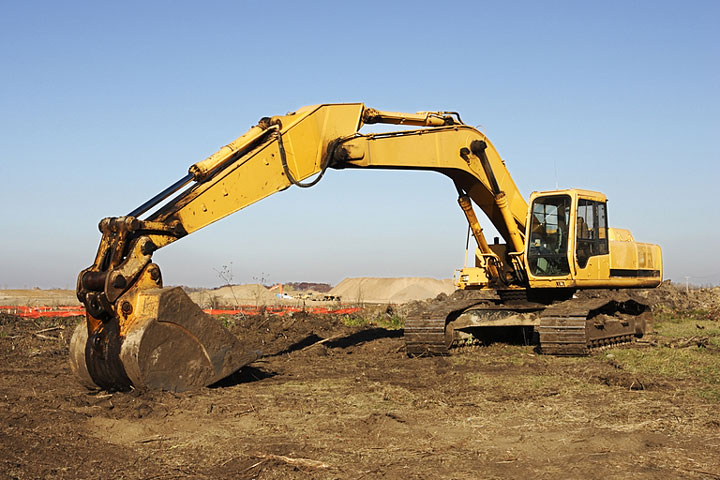

In [18]:
Image.open(train_img[2])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [19]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [20]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


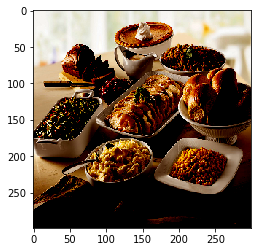

In [21]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [22]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [25]:
# tryi = model_new.predict(preprocess(train_img[0]))

In [ ]:
from keras.models import Model


In [24]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [25]:
import os

In [26]:
problematic_images = ''

In [27]:
encoding_train = {}

for img in tqdm(train_img):
    
    try:
        encoded = encode(img)

        encoding_train[img[len(images):]] = encoded
        
    except:
        print(img)
        problematic_images += img+"\n"


100%|█████████████████████████████████████████████████████████████████████████████▉| 7739/7740 [14:53<00:00,  8.66it/s]

VQg_Dataset/VQG_Dataset\problematic_images.txt


100%|██████████████████████████████████████████████████████████████████████████████| 7740/7740 [14:53<00:00,  8.66it/s]


In [28]:
import os
created_files_dir = 'vqg_created_files/'

if not os.path.exists(created_files_dir):
    os.mkdir(created_files_dir)

In [29]:
with open(created_files_dir + "encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [30]:
encoding_test = {}
for img in tqdm(test_img):
    try:
        encoded = encode(img)

        encoding_test[img[len(images):]] = encoded
        
    except:
#         print(img)
        problematic_images += img+"\n"

100%|████████████████████████████████████████████████████████████████████████████████| 967/967 [01:46<00:00,  9.04it/s]


In [31]:
with open(created_files_dir + "encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [ ]:
encoding_test[test_img[0][len(images):]].shape

In [32]:
encoding_val = {}
for img in tqdm(val_img):
    try:
        encoded = encode(img)

        encoding_val[img[len(images):]] = encoded
        
    except:
#         print(img)
        problematic_images += img+"\n"
        

100%|████████████████████████████████████████████████████████████████████████████████| 967/967 [01:52<00:00,  8.61it/s]


In [33]:
with open(images + "problematic_images.txt","w") as fh:
    fh.write(problematic_images)

In [34]:
with open(created_files_dir + "encoded_images_val_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle) 

In [ ]:
encoding_train = pickle.load(open(created_files_dir+'encoded_images_inceptionV3.p', 'rb'))

In [ ]:
encoding_test = pickle.load(open(created_files_dir+'encoded_images_test_inceptionV3.p', 'rb'))

In [ ]:
encoding_val = pickle.load(open(created_files_dir+'encoded_images_val_inceptionV3.p', 'rb'))

## Load - start

In [ ]:
encoding_val = pickle.load(open(created_files_dir + 'encoded_images_val_inceptionV3.p', 'rb'))

In [ ]:
encoding_train = pickle.load(open(created_files_dir+'encoded_images_inceptionV3.p', 'rb'))

In [ ]:
encoding_test = pickle.load(open(created_files_dir+'encoded_images_test_inceptionV3.p', 'rb'))

In [35]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [36]:
with open(created_files_dir + "img.pickle","wb")  as fh:
    pickle.dump(img,fh)

In [37]:
with open(created_files_dir + "d.pickle","wb")  as fh:
    pickle.dump(d,fh)

In [38]:
with open(created_files_dir + "train_img.pickle","wb")  as fh:
    pickle.dump(train_img,fh)

In [39]:
with open(created_files_dir + "train_d.pickle","wb")  as fh:
    pickle.dump(train_d,fh)

In [44]:
len(train_d)

7739

In [45]:
# train_d[images+'3556792157_d09d42bef7.jpg']

In [40]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [41]:
len(val_d)

967

In [42]:
with open(created_files_dir + "val_img.pickle","wb")  as fh:
    pickle.dump(val_img,fh)

In [43]:
with open(created_files_dir + "val_d.pickle","wb")  as fh:
    pickle.dump(val_d,fh)

In [44]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [45]:
len(test_d)

967

In [46]:
with open(created_files_dir + "test_img.pickle","wb")  as fh:
    pickle.dump(test_img,fh)

In [47]:
with open(created_files_dir + "test_d.pickle","wb")  as fh:
    pickle.dump(test_d,fh)

Calculating the unique words in the vocabulary.

In [48]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [49]:
with open(created_files_dir + "caps.pickle","wb")  as fh:
    pickle.dump(caps,fh)

In [50]:
words = [i.split() for i in caps]

In [51]:
unique = []
for i in words:
    unique.extend(i)

In [52]:
unique = list(set(unique))

In [53]:
with open(created_files_dir+"unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d) 

In [54]:
unique = pickle.load(open(created_files_dir+'unique.p', 'rb'))

In [55]:
len(unique)

9050

Mapping the unique words to indices and vice-versa

In [56]:
word2idx = {val:index for index, val in enumerate(unique)}

In [57]:
word2idx['<start>']

8515

In [58]:
with open(created_files_dir + "word2idx.pickle","wb")  as fh:
    pickle.dump(word2idx,fh)

In [59]:
idx2word = {index:val for index, val in enumerate(unique)}

In [60]:
idx2word[5553]

'plowed'

In [61]:
with open(created_files_dir + "idx2word.pickle","wb")  as fh:
    pickle.dump(idx2word,fh)

Calculating the maximum length among all the captions

In [62]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

23

In [63]:
with open(created_files_dir+"max_len.pickle","wb") as fh:
    pickle.dump(max_len,fh)

In [64]:
len(unique), max_len

(9050, 23)

In [65]:
vocab_size = len(unique)

In [66]:
vocab_size

9050

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [67]:
f = open(created_files_dir+'VQG_training_dataset.txt', 'w',encoding='utf-8')
f.write("image_id\tcaptions\n")

18

In [68]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [69]:
df = pd.read_csv(created_files_dir+'VQG_training_dataset.txt', delimiter='\t')

In [70]:
len(df)

38735

In [71]:
c = [i for i in df['captions']]
len(c)

38735

In [72]:
with open(created_files_dir + "c.pickle","wb")  as fh:
    pickle.dump(c,fh)

In [73]:
imgs = [i for i in df['image_id']]

In [74]:
with open(created_files_dir + "imgs.pickle","wb")  as fh:
    pickle.dump(imgs,fh)

In [76]:
a = c[-1]
a, imgs[-1]

('<start> Is that your front door <end>', '245425466__72157594287777319.jpg')

In [77]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 8515
Is => 3648
that => 7407
your => 2346
front => 8643
door => 8441
<end> => 4551


In [78]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [79]:
samples_per_epoch

275033

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [80]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv(created_files_dir+'VQG_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [81]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [82]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [83]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Merging the models and creating a softmax classifier

In [84]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [85]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [86]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 46, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 9050)              4642650   
_________________________________________________________________
activation_95 (Activation)   (None, 9050)              0         
Total params: 9,760,554
Trainable params: 9,760,554
Non-trainable params: 0
_________________________________________________________________


In [88]:
batch_size = 128
samples_pr_epoch = samples_per_epoch

In [106]:
def save_the_model(model,acc,loss,epoch):

    # serialize model to JSON
    model_json = model.to_json()
    with open(created_files_dir+"models/"+"model_{}epoch_{}loss_{}acc.json".format(epoch,loss,acc), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(created_files_dir+"models/"+"model_{}epoch_{}loss_{}acc.h5".format(epoch,loss,acc))
    print("Saved model to disk")

In [107]:
def load_the_model(model_path,weights_path):
    
    # load json and create model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model


In [89]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=4, 
                          verbose=2)

Epoch 1/4
440s - loss: 4.2123 - acc: 0.3070
Epoch 2/4
686s - loss: 3.5877 - acc: 0.3696
Epoch 3/4
405s - loss: 3.4112 - acc: 0.3884
Epoch 4/4
421s - loss: 3.3264 - acc: 0.4021


In [94]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
404s - loss: 3.3383 - acc: 0.4117


In [109]:
save_the_model(final_model,str(0.4117),str(3.3383),str(5))

Saved model to disk


In [105]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 46, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 9050)              4642650   
_________________________________________________________________
activation_95 (Activation)   (None, 9050)              0         
Total params: 9,760,554
Trainable params: 9,760,554
Non-trainable params: 0
_________________________________________________________________


In [ ]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

In [86]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
422s - loss: 3.2757 - acc: 0.4073


In [87]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
431s - loss: 3.2111 - acc: 0.4170


In [88]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
429s - loss: 3.2291 - acc: 0.4233


In [89]:
# final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
427s - loss: 3.2124 - acc: 0.4287


In [90]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
435s - loss: 3.2285 - acc: 0.4326


In [91]:
if not os.path.exists(created_files_dir+"models/"):
    os.mkdir(created_files_dir+"models/")

In [92]:
final_model.save_weights(created_files_dir+"models/"+'time_inceptionV3_7_loss_3.2285.h5')

In [93]:
final_model.load_weights(created_files_dir+"models/"+'time_inceptionV3_7_loss_3.2285.h5')

In [94]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
415s - loss: 3.2017 - acc: 0.4383


In [109]:
final_model.save_weights(created_files_dir+"models/"+'time_inceptionV3_7_loss_3.2017.h5')

In [ ]:
final_model.load_weights(created_files_dir+"models/"+'time_inceptionV3_7_loss_3.2017.h5')

In [117]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
388s - loss: 3.1961 - acc: 0.4428


In [ ]:
# final_model.save_weights(created_files_dir+"models/"+'time_inceptionV3_3.21_loss.h5')

In [118]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
423s - loss: 3.1934 - acc: 0.4466


In [119]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
424s - loss: 3.1545 - acc: 0.4505


In [120]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=1, 
                          verbose=2)

Epoch 1/1
429s - loss: 3.1248 - acc: 0.4548


In [135]:
final_model.save_weights(created_files_dir+"models/"+'time_inceptionV3_13epochs_3.1248loss_45acc.h5')

In [ ]:
final_model.load_weights(created_files_dir+"models/"+'time_inceptionV3_13epochs_3.1248loss_45acc.h5')

In [136]:
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=5, 
                          verbose=2)

Epoch 1/5
406s - loss: 3.0970 - acc: 0.4597
Epoch 2/5
425s - loss: 3.0712 - acc: 0.4644
Epoch 3/5
429s - loss: 3.0716 - acc: 0.4676
Epoch 4/5
424s - loss: 3.0326 - acc: 0.4703
Epoch 5/5
428s - loss: 3.0077 - acc: 0.4741


In [137]:
final_model.save_weights(created_files_dir+"models/"+'time_inceptionV3_18epochs_3.0077loss_4741acc.h5')

In [81]:
final_model.load_weights(created_files_dir+"models/"+'time_inceptionV3_18epochs_3.0077loss_4741acc.h5')

In [ ]:
# final_model.load_weights(created_files_dir+"models/"+'time_inceptionV3_1.5987_loss.h5')

## Predict funtion

In [95]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [96]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

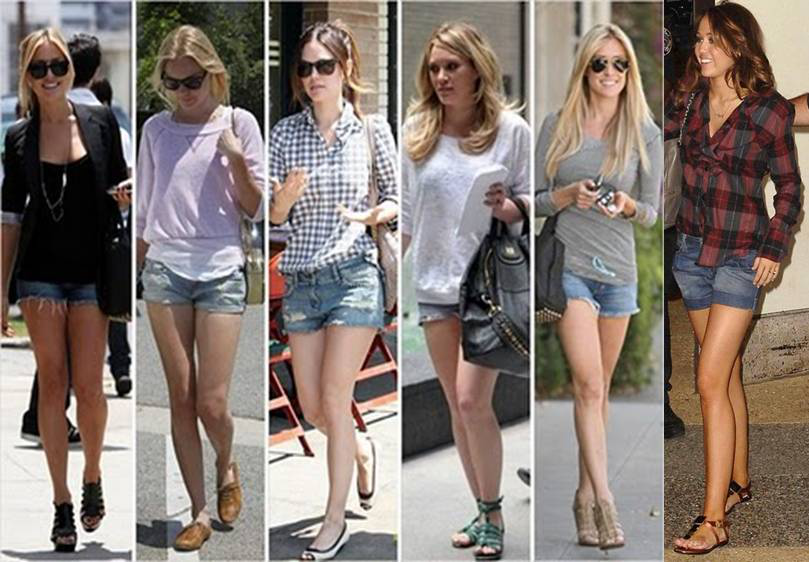

In [97]:
try_image = test_img[0]
Image.open(try_image)

In [98]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: What is the name of this woman
Beam Search, k=3: Is this a wedding
Beam Search, k=5: Who is she
Beam Search, k=7: Who is she


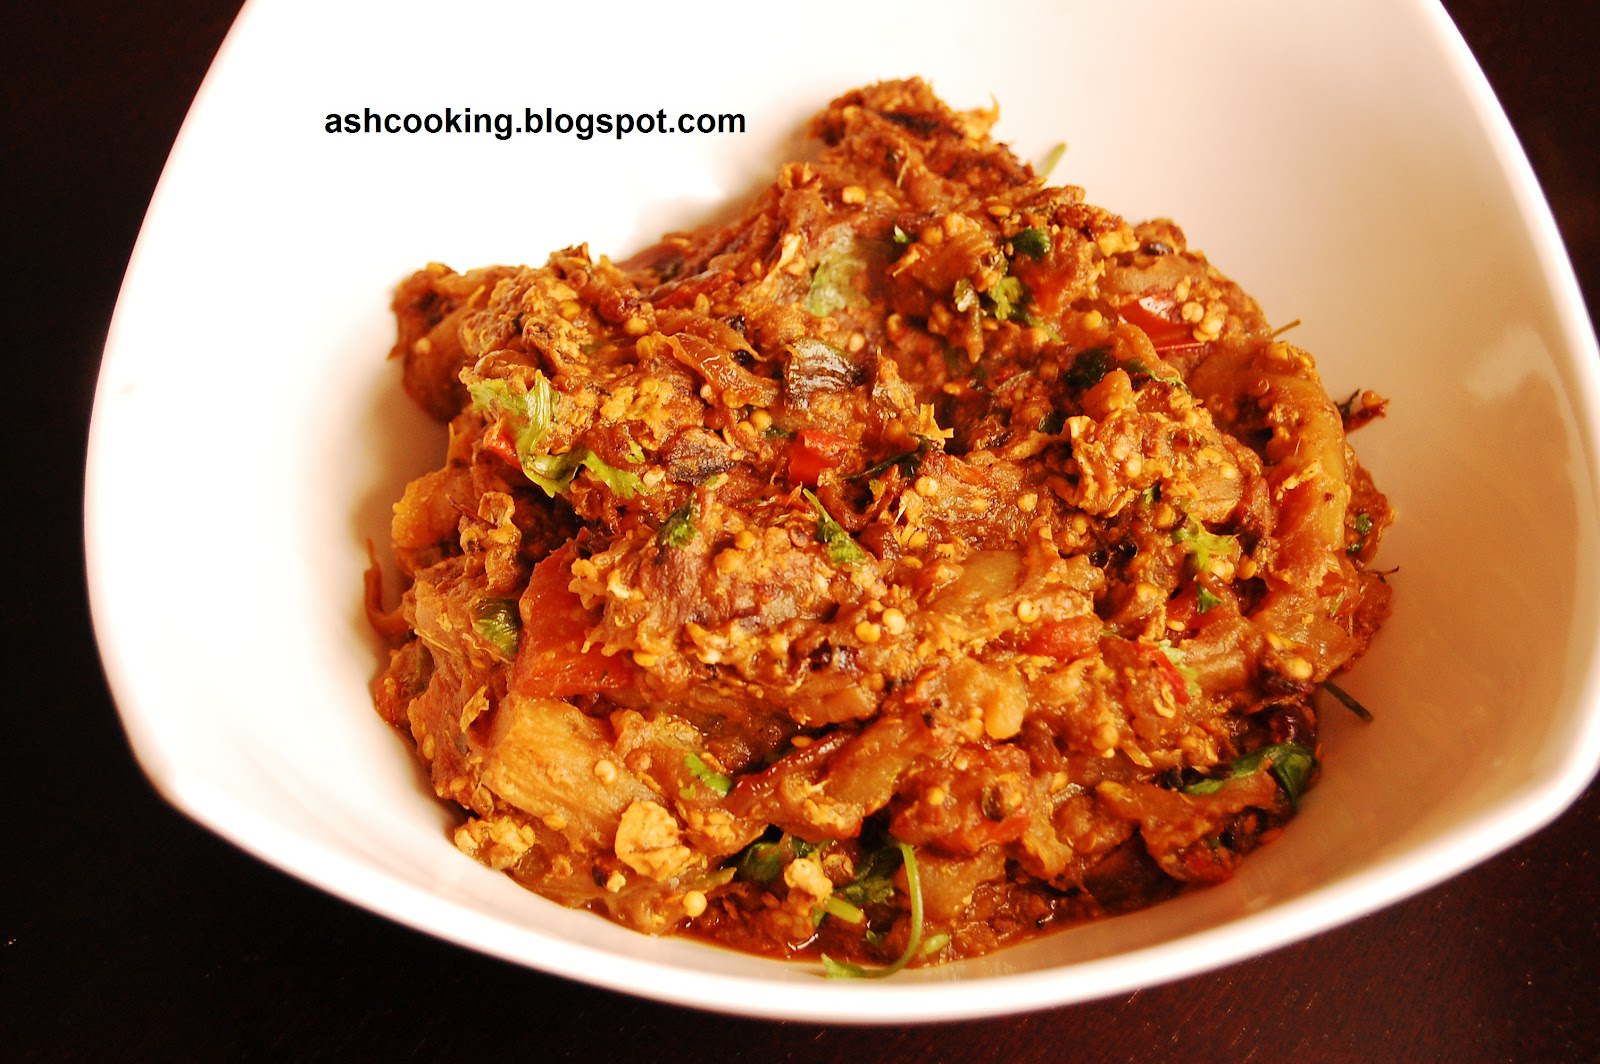

In [99]:
try_image2 = test_img[7]
Image.open(try_image2)

In [100]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: What kind of pizza is that
Beam Search, k=3: What kind of pizza is that
Beam Search, k=5: What kind of pizza is that
Beam Search, k=7: What kind of pizza is that


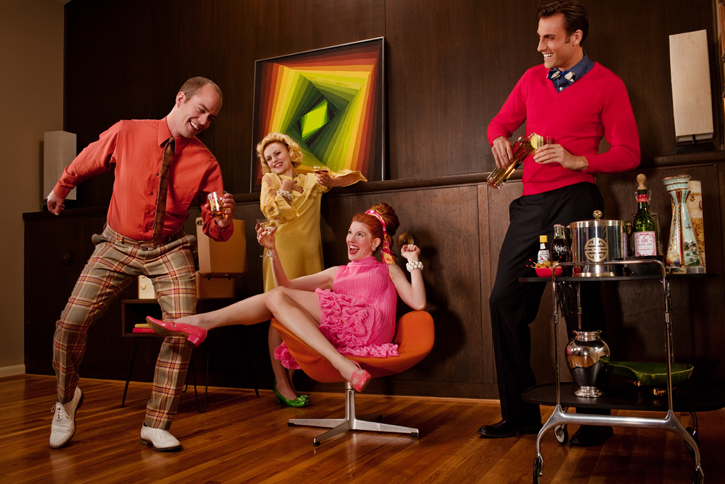

In [101]:
try_image3 = test_img[900]
Image.open(try_image3)

In [102]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: What is she celebrating
Beam Search, k=3: What kind of flowers are they
Beam Search, k=5: What kind of flowers are they
Beam Search, k=7: What kind of flowers are they


In [ ]:
try_image4 = 'VQg_dataset/VQG_Dataset/476634.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: Is that your favorite cat
Beam Search, k=3: Is that a new computer
Beam Search, k=5: Is that your favorite cat
Beam Search, k=7: Why are there so many computers


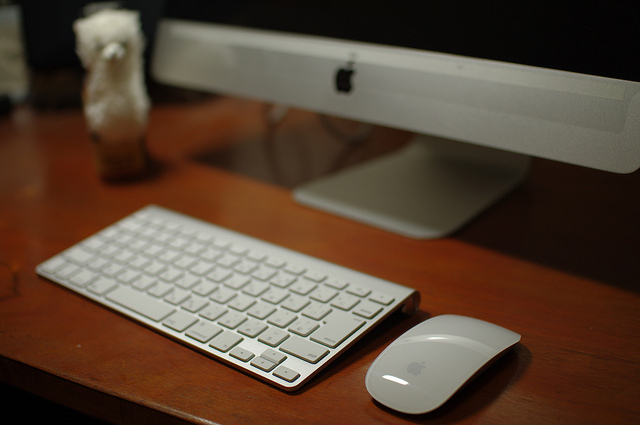

In [147]:
im = 'VQg_dataset/VQG_Dataset/151170.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What is this machine used for
Beam Search, k=3: What kind of machine is this
Beam Search, k=5: What does this machine do
Beam Search, k=7: What does this machine do


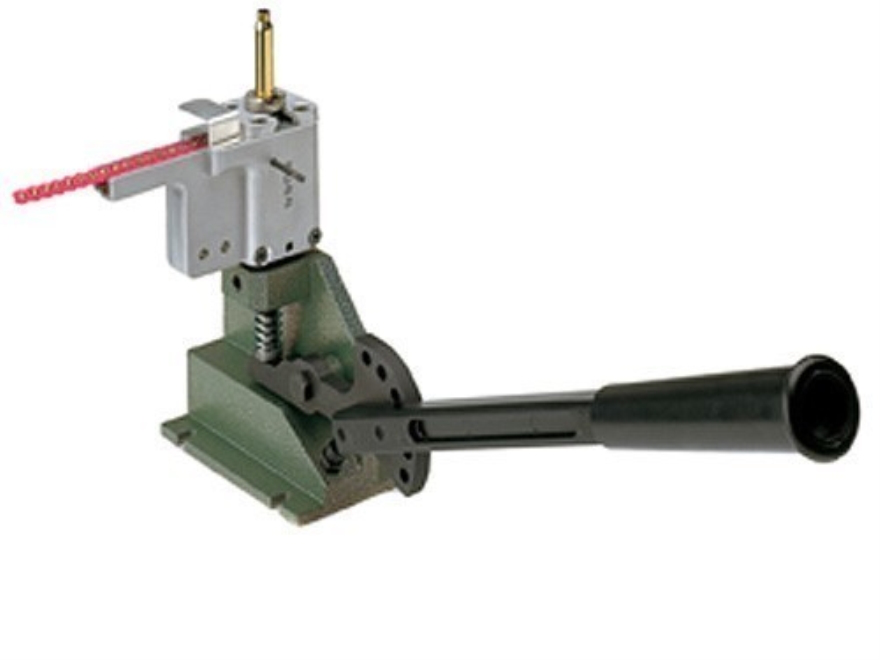

In [148]:
im = 'VQg_dataset/VQG_Dataset/bf1f3ad3-a667-49e3-9148-f0ad2d018b1b.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What is the bike bike on the bike
Beam Search, k=3: What kind of motorcycle is that
Beam Search, k=5: What kind of motorcycle is that
Beam Search, k=7: What kind of motorcycle is that


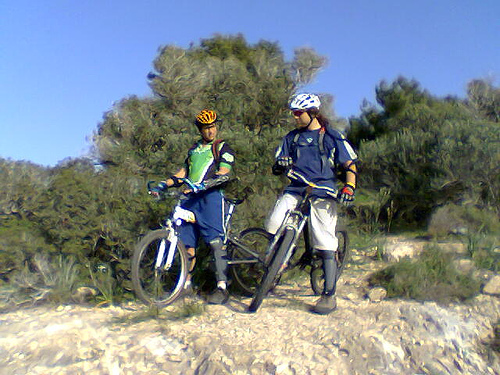

In [104]:
im = 'VQg_dataset/VQG_Dataset/42493.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What body of water is that
Beam Search, k=3: What body of water is that
Beam Search, k=5: What body of water is that
Beam Search, k=7: What body of water is that


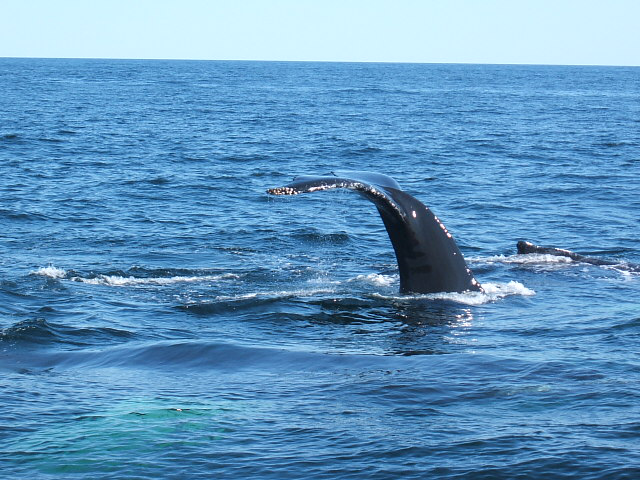

In [150]:
im = 'VQg_dataset/VQG_Dataset/229320189__72157594260126384.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What breed of cat is that
Beam Search, k=3: What breed of cat is it
Beam Search, k=5: How old is the cat
Beam Search, k=7: What's the cat's name


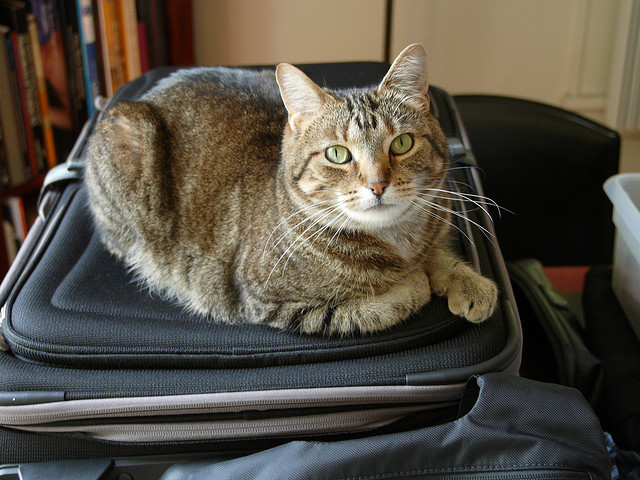

In [151]:
im = 'VQg_dataset/VQG_Dataset/308549.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A skateboarder in the air in front of a red slide .
Beam Search, k=3: A skateboarder in the air in front of a blue building .
Beam Search, k=5: A skateboarder in the air in front of a blue building .
Beam Search, k=7: A male skateboarder is skating in a skate park .


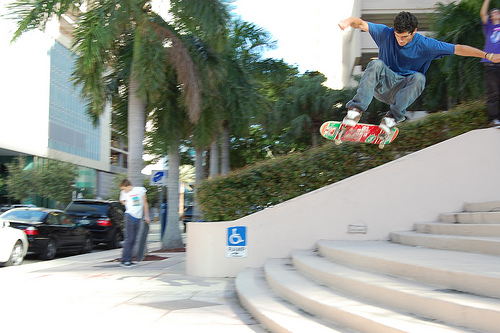

In [69]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A small dog jumping an obstacle in a grassy field .
Beam Search, k=3: A small dog jumping an obstacle in a grassy field .
Beam Search, k=5: A small dog jumping an obstacle in a grassy field .
Beam Search, k=7: A small dog jumping an obstacle in a grassy field .


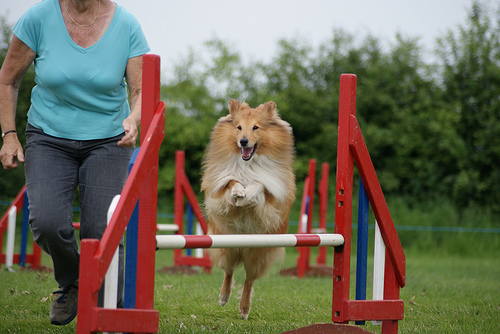

In [77]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Flickr8k_Dataset/Flicker8k_Dataset/3123351642_3794f2f601.jpg
Normal Max search: A snowboarder is riding down the ramp next to a hill .
Beam Search, k=3: A person on a snowboard jumps over a cliff in the snow .
Beam Search, k=5: A person on a snowboard jumps over a cliff in the snow .
Beam Search, k=7: A person on a snowboard jumps over a cliff in the snow .


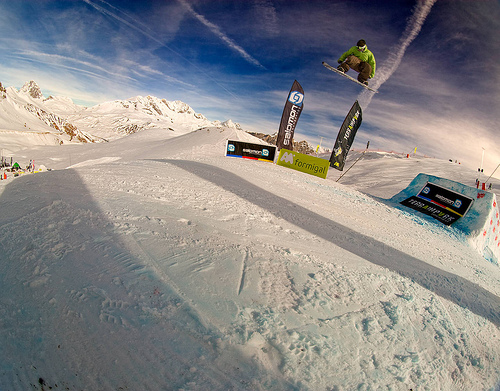

In [103]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)